In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import romberg
from scipy.stats import norm
import paramonte as pm
from LogLumDisWicMPC import getLogLumDisWicMPC
sns.set()

In [3]:
df = pd.read_excel("L19figure1.xlsx", header = 0)

In [4]:
z = df.iloc[:,0]
zone = z + 1
logZone = np.log(zone)
logZone.name = "log (z + 1)"

In [5]:
type(logZone)

pandas.core.series.Series

In [18]:
eiso = df.iloc[:,2] * 1.0e52
logEiso = np.log(eiso)
logEiso.name = "log (Eiso)"

<IPython.core.display.Javascript object>


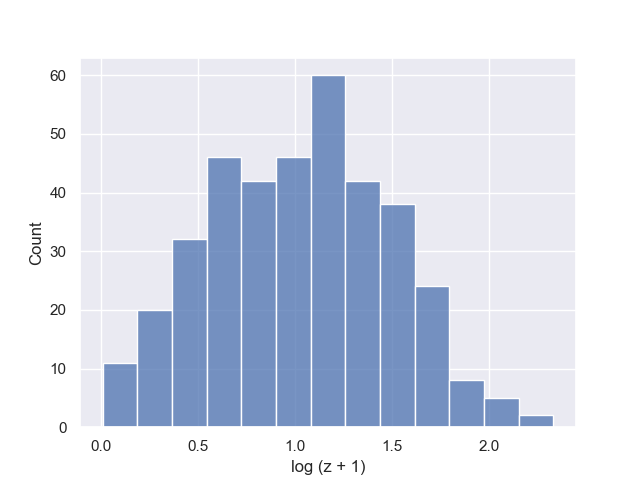

In [7]:
fig = plt.figure()
ax = fig.gca()
sns.histplot(logZone)
plt.show()

In [8]:
print("logZone mean: " + str(round(logZone.mean(),3)))
print("logZone std: " + str(round(logZone.std(),3)))

logZone mean: 1.024
logZone std: 0.462


<IPython.core.display.Javascript object>


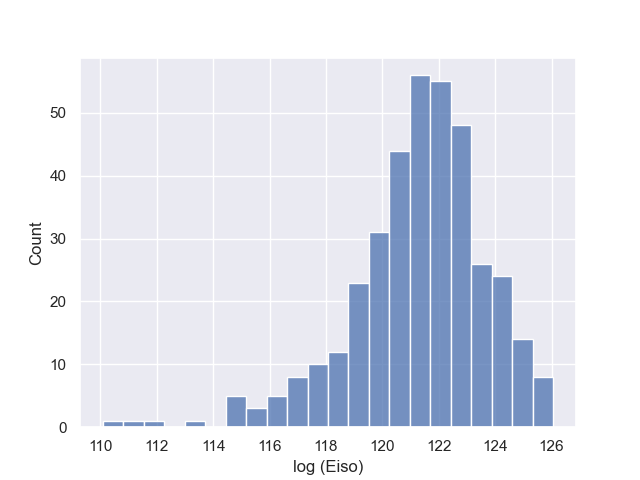

In [19]:
fig = plt.figure()
ax = fig.gca()
sns.histplot(logEiso)
plt.show()

In [15]:
print("logEiso mean: " + str(round(logEiso.mean(),3)))
print("logEiso std: " + str(round(logEiso.std(),3)))

logEiso mean: 121.266
logEiso std: 2.41


<IPython.core.display.Javascript object>


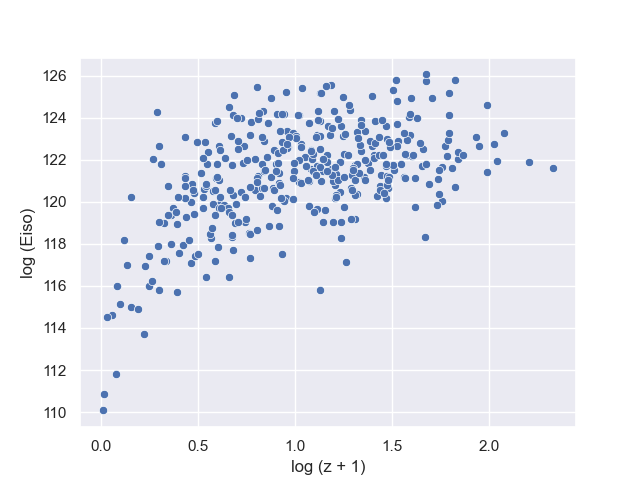

In [23]:
fig = plt.figure()
ax = fig.gca()
sns.scatterplot(x = logZone, y = logEiso)
plt.show()

In [16]:
class Normal():
    
    def __init__(self, logZone, logEiso):
        if len(logZone) != len(logEiso): return print("Error: dataset lengths not equivalent")
        
        self.data = np.transpose(np.double([logZone,logEiso]))
        self.ndata = len(logZone)
        self.NDIM = 2
        self.coef0 = self.NDIM * np.log( 1. / np.sqrt(2.*np.pi) )
        
    def getLogThreshLim(self, logZoneIn):
        MPC2CM = 3.09e24
        LOGMPC2CMSQ4PI = np.log(4.0*np.pi) + 2.0*np.log(MPC2CM)
        zone = np.exp(logZoneIn)
        logThresh = LOGMPC2CMSQ4PI + 2*getLogLumDisWicMPC(zone) + self.logThreshLim - logZoneIn
        return logThresh
    
    def getThreshCutY(self, logZoneIn):
        threshGridPoint = np.exp(self.getLogThreshLim(logZoneIn))
        return threshGridPoint
    
    def integrateYGivenX(self, xval):
        avgYGivenX = self._meanVec[1] + self._stdRatio * self._rho * (xval - self._meanVec[0])
        threshY = self.getThreshCutY(xval) 
        return norm.pdf(x = xval, loc = self._meanVec[0], scale = self._stdX) \
             * (1-norm.cdf(x = threshY, loc = avgYGivenX, scale = self._stdYGivenX))

    def getNormFac(self):
        return romberg( function = self.integrateYGivenX
                      , a = self._lowerLimX
                      , b = self._upperLimX
                      )
    
    def getLogLike(self, param):
        """
        Order of variables in param:
        param[0] = avg(x)
        param[1] = avg(y)
        param[2] = logStd(x)
        param[3] = logStd(y)
        param[4] = FisherTrans(self._rho)
        param[5] = logThreshLim
        """
        self._rho = np.tanh(param[4]) # inverse Fisher transform
        self._meanVec = np.double(param[0:2])
        self._covMat = np.zeros([self.NDIM,self.NDIM])
        self._stdX = np.exp(param[2])
        self._stdY = np.exp(param[3])
        self._covMat[0,0] = (self._stdX)**2
        self._covMat[1,1] = (self._stdY)**2
        self._covMat[1,0] = self._rho * self._stdX * self._stdY
        self._covMat[0,1] = self._covMat[1,0]
        
        if np.linalg.det(self._covMat) == 0: 
            import sys
            sys.exit("disaster happended.")
        
        self._stdYGivenX = np.sqrt( self._covMat[1,1] * (1-self._rho**2) )
        self._stdRatio = self._stdY / self._stdX
        self.logThreshLim = param[5]
        logVerticalDistFromThreshLine = self.data[1] - self.getLogThreshLim(self.data[0]) + self.logThreshLim
        self.mindata = min(logVerticalDistFromThreshLine)
        #significance = 4 * self._stdX
        self._lowerLimX = min(self.data[0]) #self._meanVec[0] - significance
        self._upperLimX = max(self.data[0]) #self._meanVec[0] + significance
        

        
        # This is the inverse of the covariance matrix of the MVN distribution.
        invCovMat = np.linalg.inv(self._covMat)
        
        # The following is the log of the coefficient used in the definition of the MVN.
        coef = self.coef0 + np.log( np.sqrt(np.linalg.det(invCovMat)) )
        
        # the logarithm of objective function: log(MVN)
        logLike = 0.
        for obs in self.data:
            if self.logThreshLim > self.mindata: 
                return -1e100
            else:
                normedPoint = self._meanVec - obs
                logLike += coef - 0.5 * ( np.dot(normedPoint, np.matmul(invCovMat,normedPoint)) )
        return logLike - np.log(self.getNormFac())*self.ndata

In [17]:
normal = Normal(logZone,logEiso)

In [18]:
pmpd = pm.ParaDRAM()

In [19]:
pmpd.spec.chainSize = 20000
pmpd.spec.variableNameList = ["Average X", "Average Y", "LogStd X", "LogStd Y", "FisherTrans(rho)", "logThreshLim"]
pmpd.spec.startPointVec = [1.2,116,np.log(0.5),np.log(2.4),0,np.log(1e-8)]
pmpd.spec.targetAcceptanceRate = [0.1,0.3]

In [20]:
pmpd.runSampler( ndim = 3
               , getLogFunc = normal.getLogLike
               )


ParaDRAM - NOTE: Running the ParaDRAM sampler in serial mode...
ParaDRAM - NOTE: To run the ParaDRAM sampler in parallel mode visit:
ParaDRAM - NOTE: 
ParaDRAM - NOTE:     https://www.cdslab.org/paramonte
ParaDRAM - NOTE: 
ParaDRAM - NOTE: If you are using Jupyter notebook, check the Jupyter's 
ParaDRAM - NOTE: terminal window for realtime simulation progress and report.



<ipython-input-16-c76213c7a48f>:29: RuntimeWarning: invalid value encountered in log
  self.logThreshLim = np.log(param[2])
<ipython-input-16-c76213c7a48f>:20: RuntimeWarning: divide by zero encountered in log
  return coef - logStd - 0.5*((verticalDistFromThreshLine - avg)/std)**2 - np.log(norm.cdf(self.ThreshLim, avg, std))
<ipython-input-16-c76213c7a48f>:17: RuntimeWarning: overflow encountered in exp
  std = np.exp(logStd)



ParaDRAM - FATAL: The simulation failed. For more information, checkout the 
ParaDRAM - FATAL: simulation output error message on your your Bash / Python 
ParaDRAM - FATAL: terminal or command-prompt, also at the end of the output report 
ParaDRAM - FATAL: file, if it has been generated:
ParaDRAM - FATAL: 
ParaDRAM - FATAL:     C:\Users\cmbac\Python\Lloyd19\ParaDRAM_run_20201005_175017_894_report.txt
ParaDRAM - FATAL: 
ParaDRAM - FATAL: It appears that an old ParaDRAM simulation with 
ParaDRAM - FATAL: the same output file names exists in the specified path:
ParaDRAM - FATAL: 
ParaDRAM - FATAL: C:\Users\cmbac\Python\Lloyd19\ParaDRAM_run_20201005_175017_894_process_1_chain.txt
ParaDRAM - FATAL: C:\Users\cmbac\Python\Lloyd19\ParaDRAM_run_20201005_175017_894_process_1_progress.txt
ParaDRAM - FATAL: C:\Users\cmbac\Python\Lloyd19\ParaDRAM_run_20201005_175017_894_process_1_report.txt
ParaDRAM - FATAL: C:\Users\cmbac\Python\Lloyd19\ParaDRAM_run_20201005_175017_894_process_1_restart.bin
ParaD

Exception: Fatal error occurred. Gracefully exiting.

In [ ]:
pmpd.readSample()

In [ ]:
pmpd.sampleList[0].df.mean()